In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base=automap_base()
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    session.close

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = "2017-08-01"
end_date = "2017-08-07"
vacation=calc_temps(start_date,end_date)

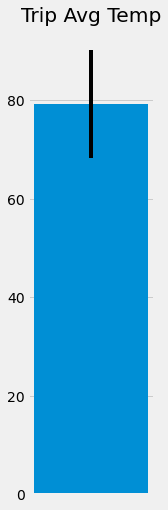

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,8))
plt.bar(1,vacation[0][1],yerr=vacation[0][2]-vacation[0][0])
plt.title("Trip Avg Temp")
plt.xticks([])
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session = Session(engine)
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
rainfall = session.query(*sel,func.sum(Measurement.prcp)).group_by(Measurement.prcp).order_by(func.sum(Measurement.prcp).desc()).\
            filter(Measurement.date >= start_date).filter(Measurement.date<=end_date).\
            filter(Measurement.station==Station.station).all()
rainfall_rows = [{"Station":data[0],"Name":data[1],"Latitude":data[2],"Longitude":data[3],"Elevation":data[4],"Total Rainfall":data[5]} \
                 for data in rainfall]
total_rain_df = pd.DataFrame(rainfall_rows)
total_rain_df

,Station,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.25
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.12
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.10
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.04
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.01
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,NaN


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).\
    filter(Measurement.date <=end_date).distinct().all()

# Strip off the year and save a list of strings in the format %m-%d
normalized = []
for date in dates:
    normalized.append(date[0][5:])


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]
for date in normalized:
    value = daily_normals(date)
    normals.append(tuple(value))
print(normals)


[((67.0, 75.54, 83.0),), ((68.0, 75.60377358490567, 84.0),), ((70.0, 76.61111111111111, 85.0),), ((69.0, 76.71153846153847, 84.0),), ((69.0, 76.14814814814815, 82.0),), ((67.0, 76.25, 83.0),), ((71.0, 77.15686274509804, 83.0),)]


In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_rows = [{"Min Temp":data[0][0],"Avg Temp":data[0][1],"Max Temp":data[0][2]} for data in normals]
trip_df = pd.DataFrame(trip_rows)
date_normalized=[]
for date in dates:
    date_normalized.append(date[0])
    
trip_df["Date"]=date_normalized
trip_df=trip_df.set_index("Date")
trip_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


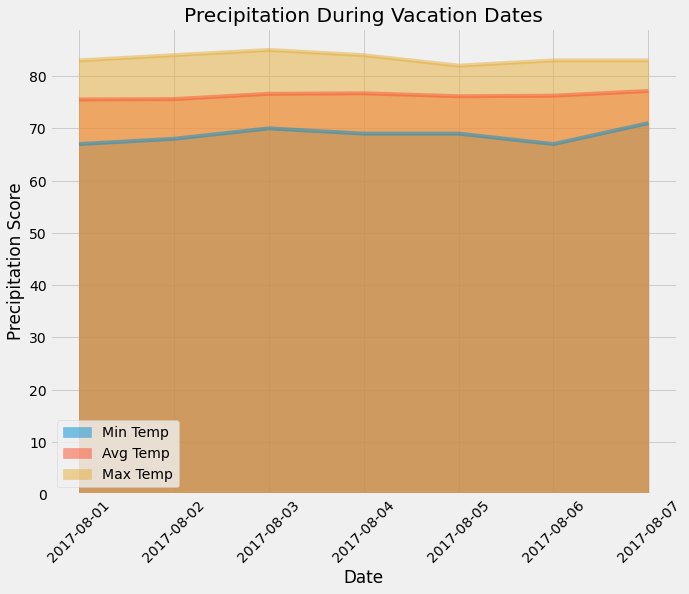

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False,figsize=(10,8))
plt.xticks(rotation=45)
plt.title("Precipitation During Vacation Dates")
plt.ylabel("Precipitation Score")
plt.show()

## Close Session

In [17]:
session.close()